# Assignment 5, Question 6: Data Transformation

**Points: 20**

Transform and engineer features from the clinical trial dataset.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import utilities
from q3_data_utils import load_data, clean_data, transform_types, create_bins, fill_missing

df = load_data('data/clinical_trial_raw.csv')
print(f"Loaded {len(df)} patients")

# Clean the data
df = clean_data(df)
print(f"After cleaning: {len(df)} patients with {len(df.columns)} variables")

# Prewritten visualization functions for transformation analysis
def plot_distribution(series, title, figsize=(10, 6)):
    """
    Create a histogram of a numeric series.
    
    Args:
        series: pandas Series with numeric data
        title: Chart title
        figsize: Figure size tuple
    """
    plt.figure(figsize=figsize)
    series.hist(bins=30)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


def plot_value_counts(series, title, figsize=(10, 6)):
    """
    Create a bar chart of value counts.
    
    Args:
        series: pandas Series with value counts
        title: Chart title
        figsize: Figure size tuple
    """
    plt.figure(figsize=figsize)
    series.plot(kind='bar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Loaded 10000 patients
After cleaning: 10000 patients with 19 variables


## Part 1: Type Conversions (5 points)

1. Convert 'enrollment_date' to datetime using the `transform_types()` utility
2. Convert categorical columns ('site', 'intervention_group', 'sex') to category dtype
3. Ensure all numeric columns are proper numeric types
4. Display the updated dtypes

Numeric columns and their dtypes after conversion:


/tmp/ipykernel_17047/154644969.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  final_df[col] = pd.to_numeric(final_df[col], errors='ignore')


patient_id                    object
age                          float64
sex                         category
bmi                          float64
enrollment_date       datetime64[ns]
systolic_bp                  float64
diastolic_bp                 float64
cholesterol_total            float64
cholesterol_hdl              float64
cholesterol_ldl              float64
glucose_fasting              float64
site                        category
intervention_group          category
follow_up_months               int64
adverse_events                 int64
outcome_cvd                   object
adherence_pct                float64
dropout                       object
enrollment_date_dt    datetime64[ns]
dtype: object

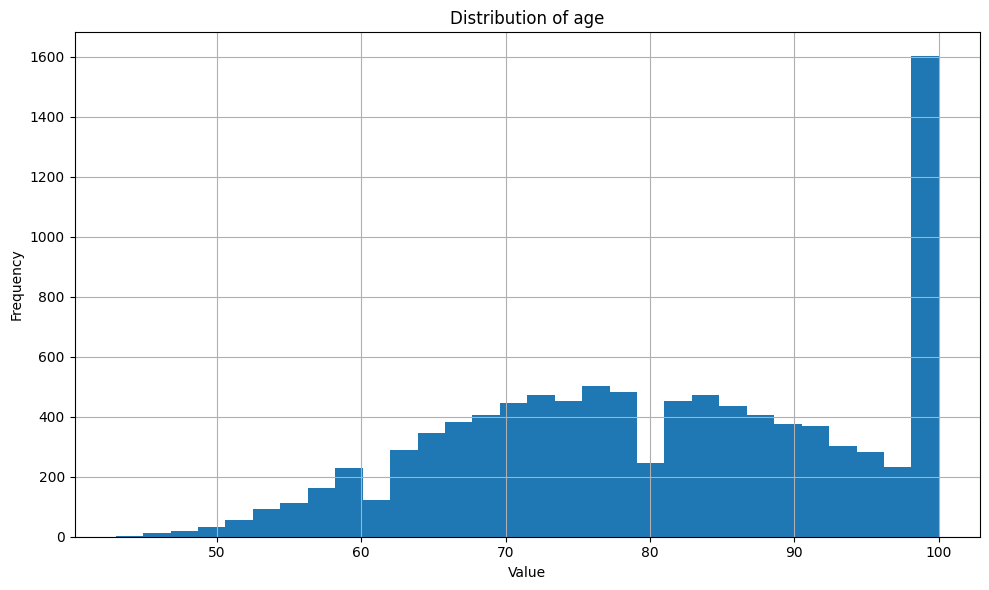

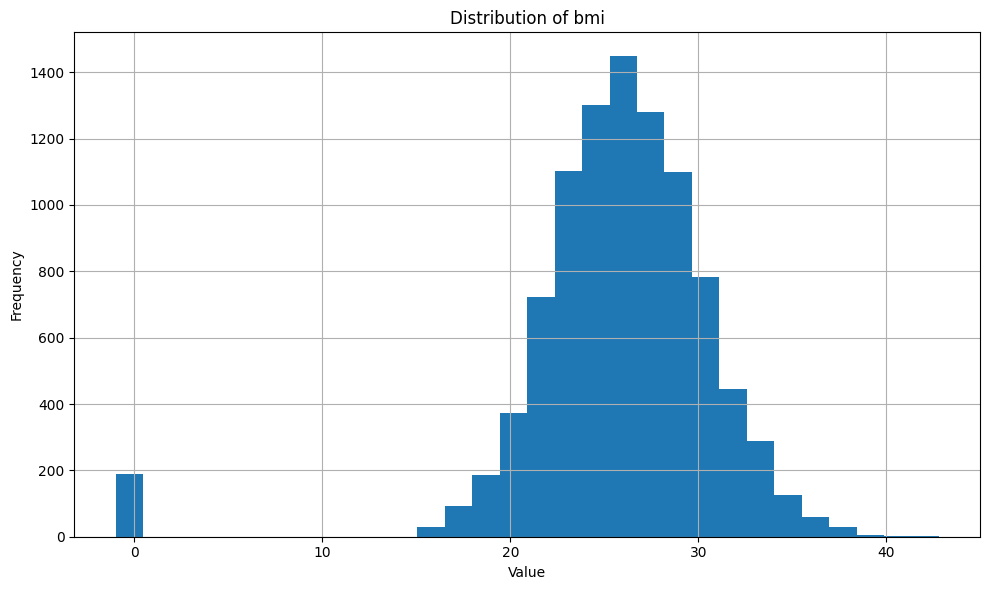

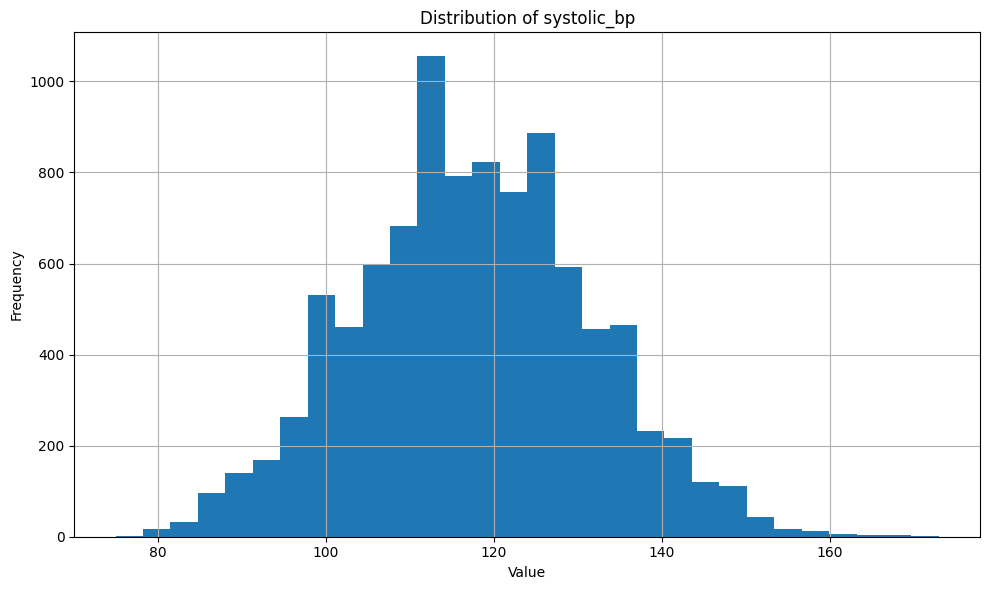

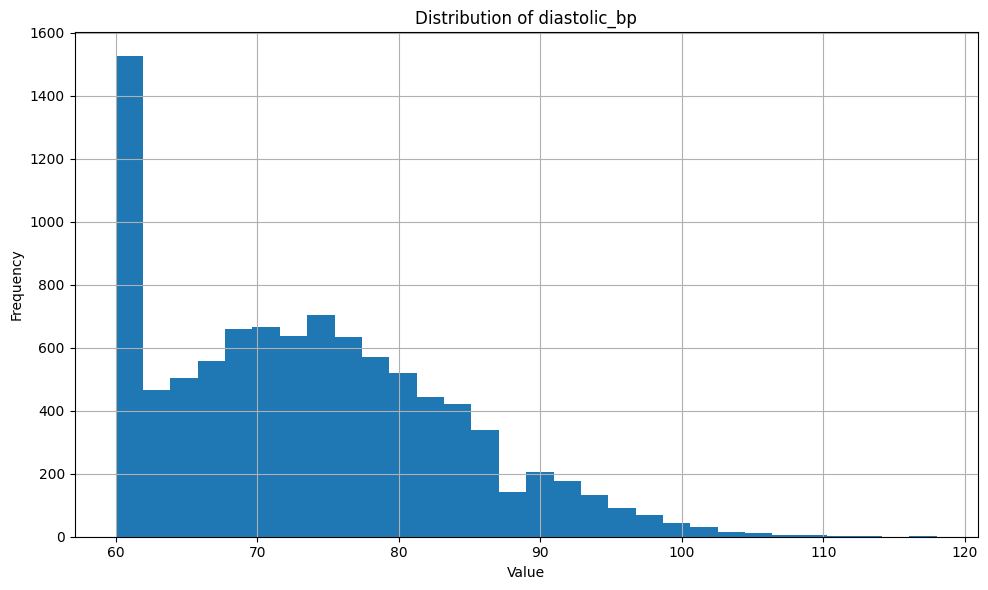

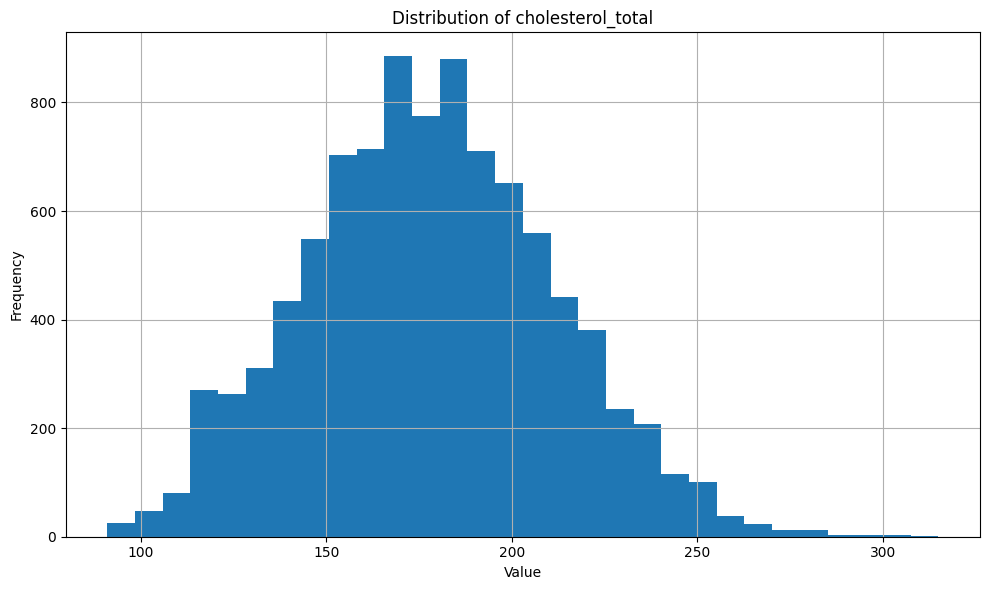

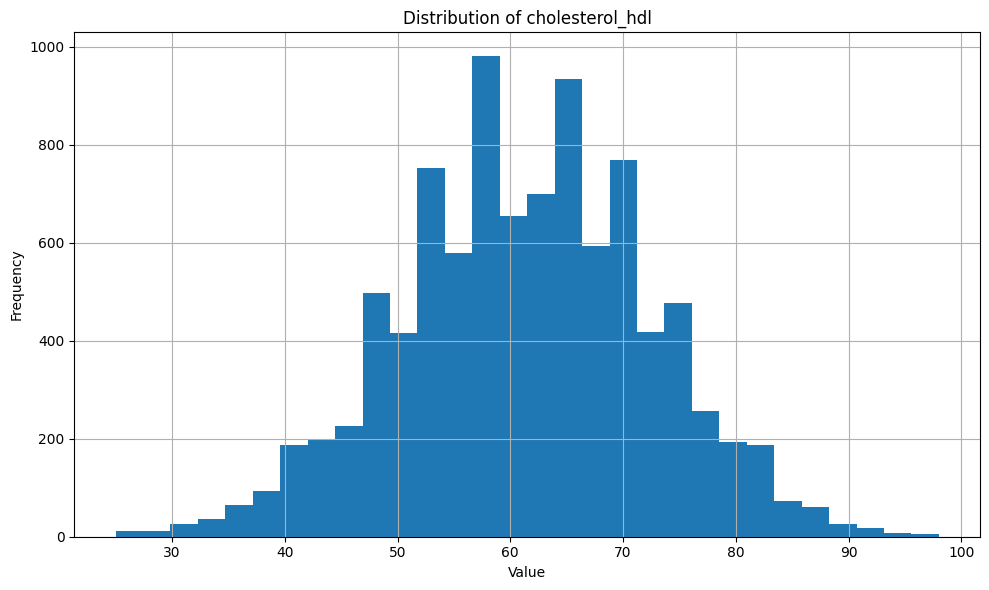

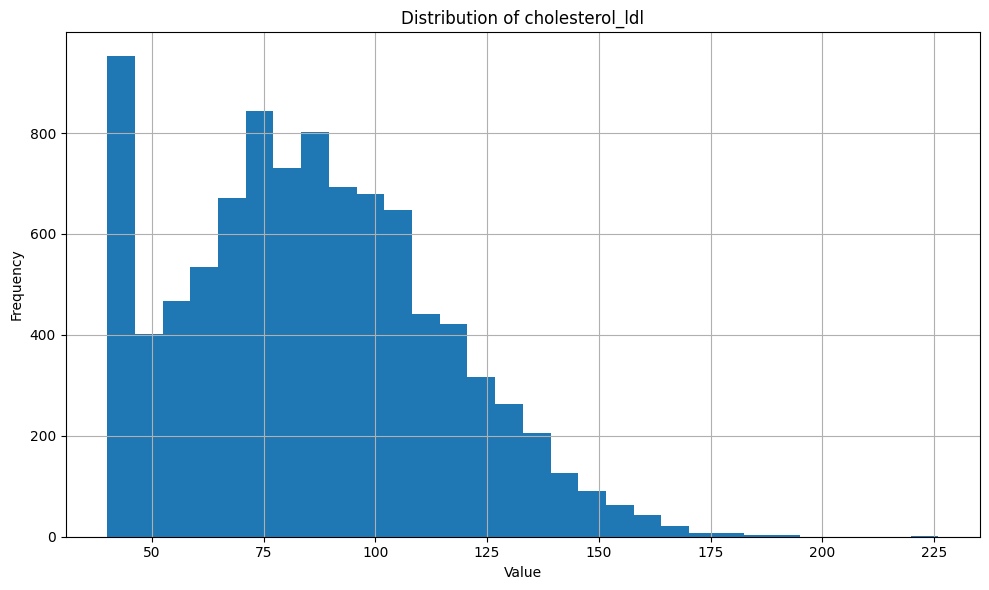

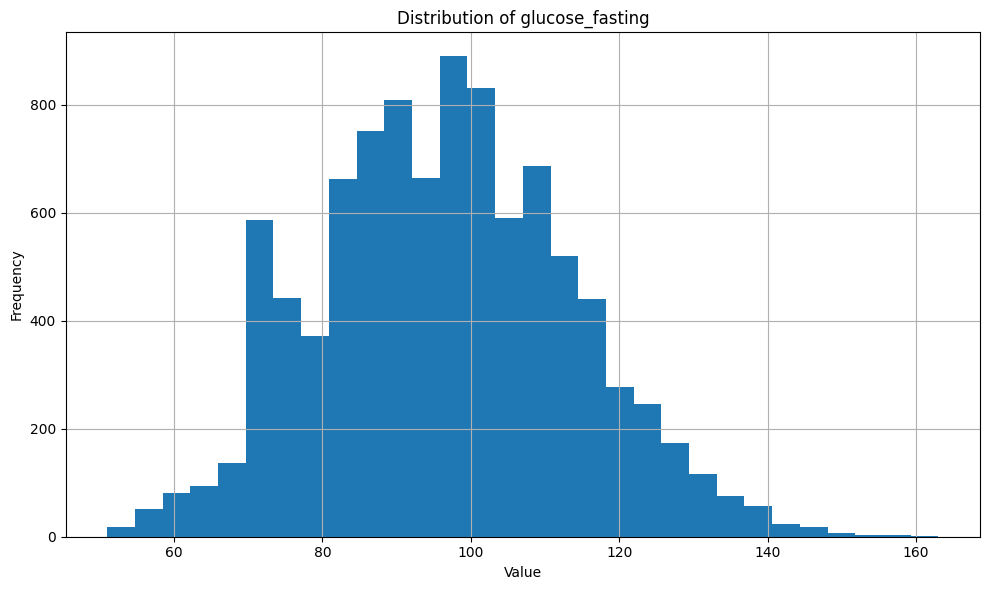

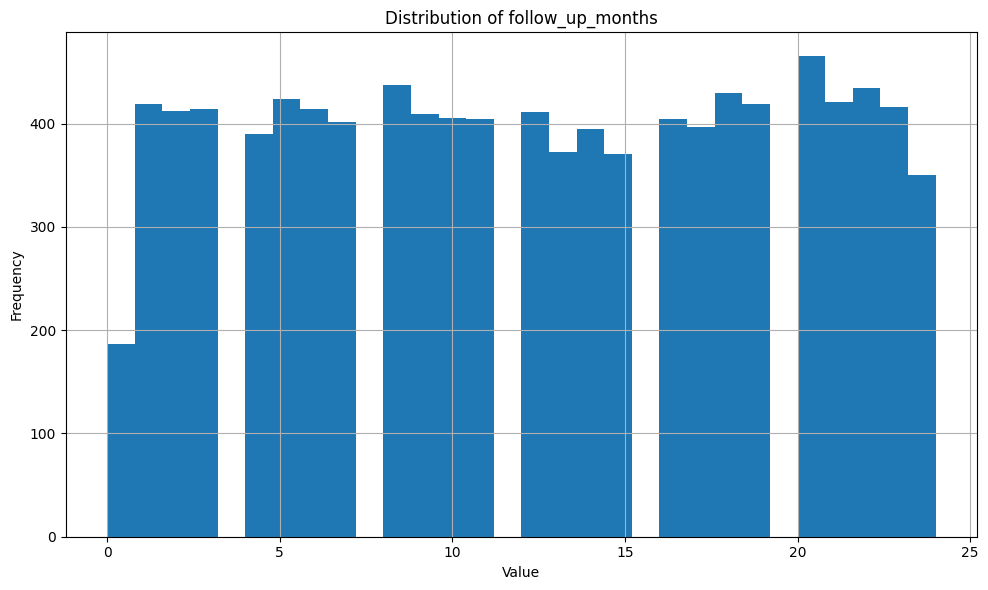

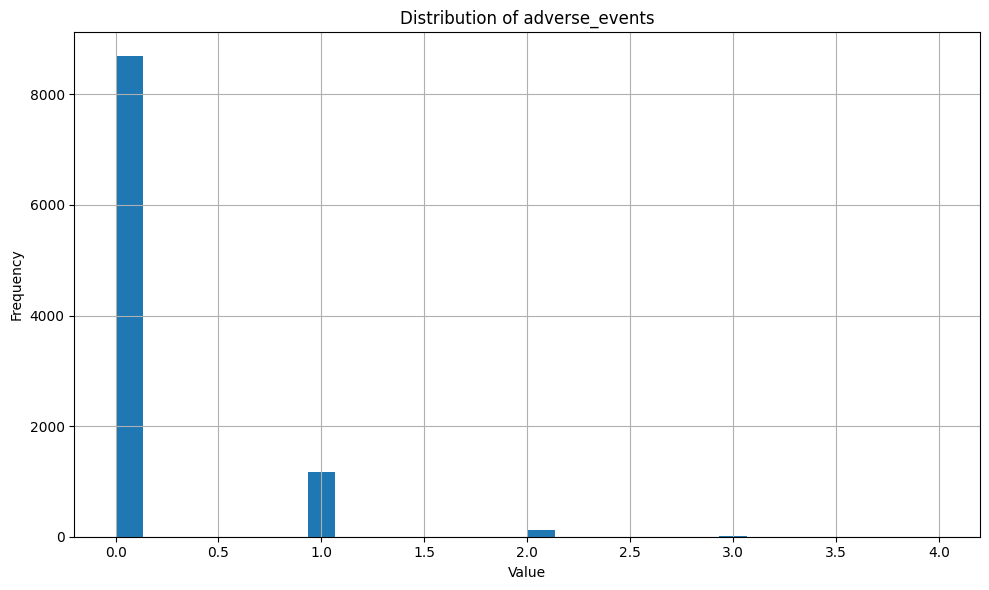

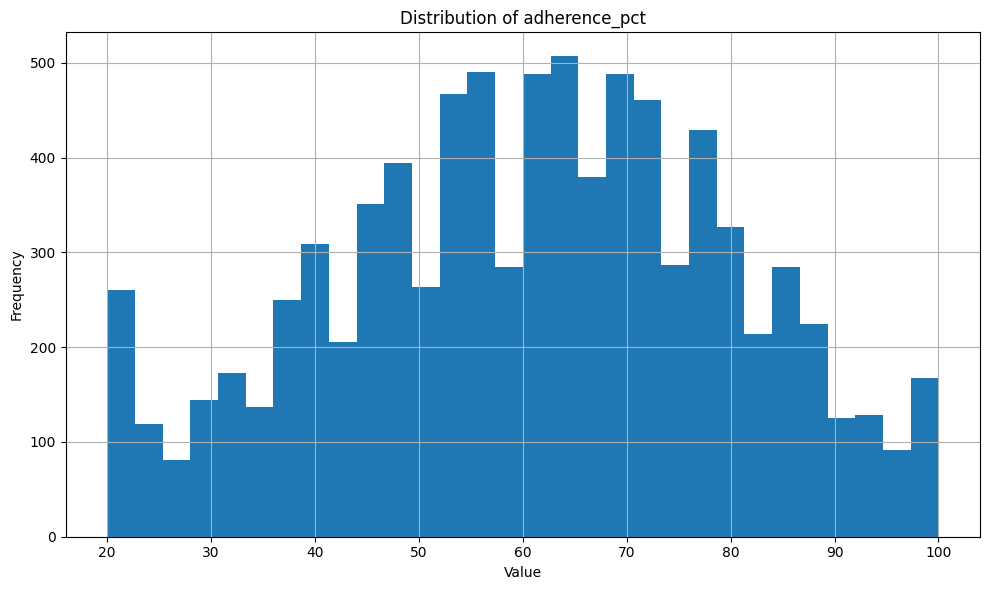

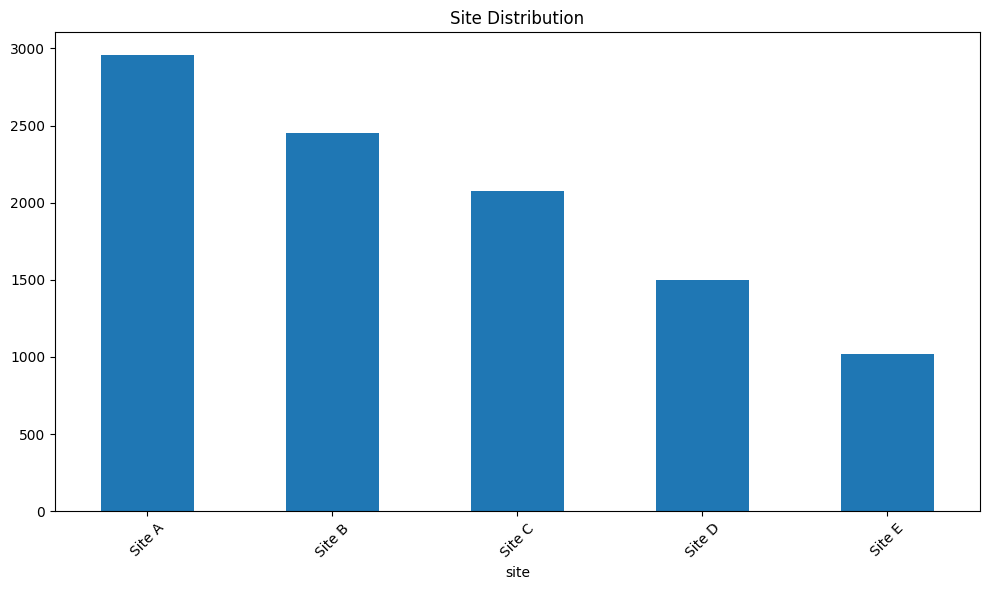

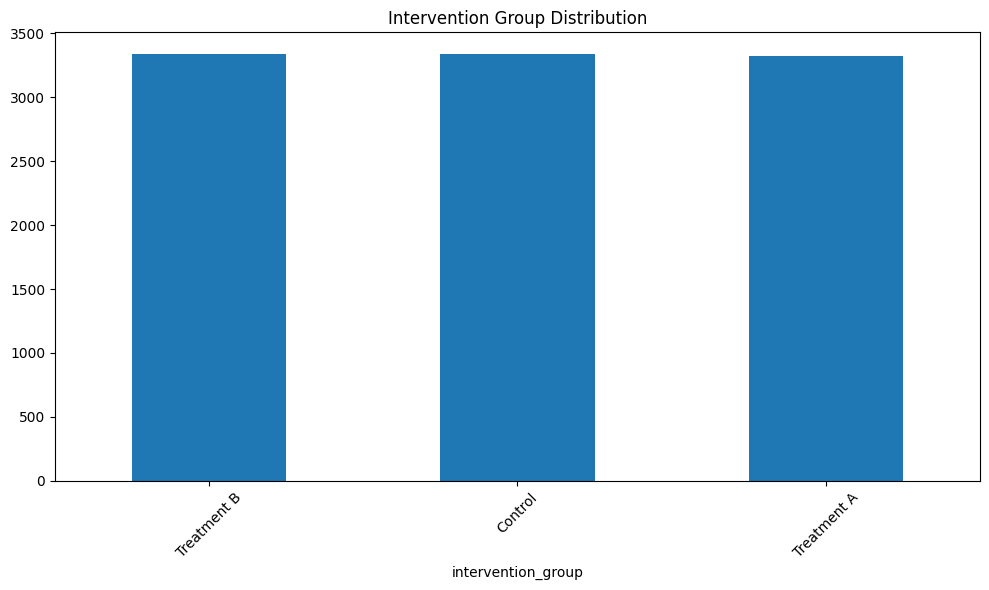

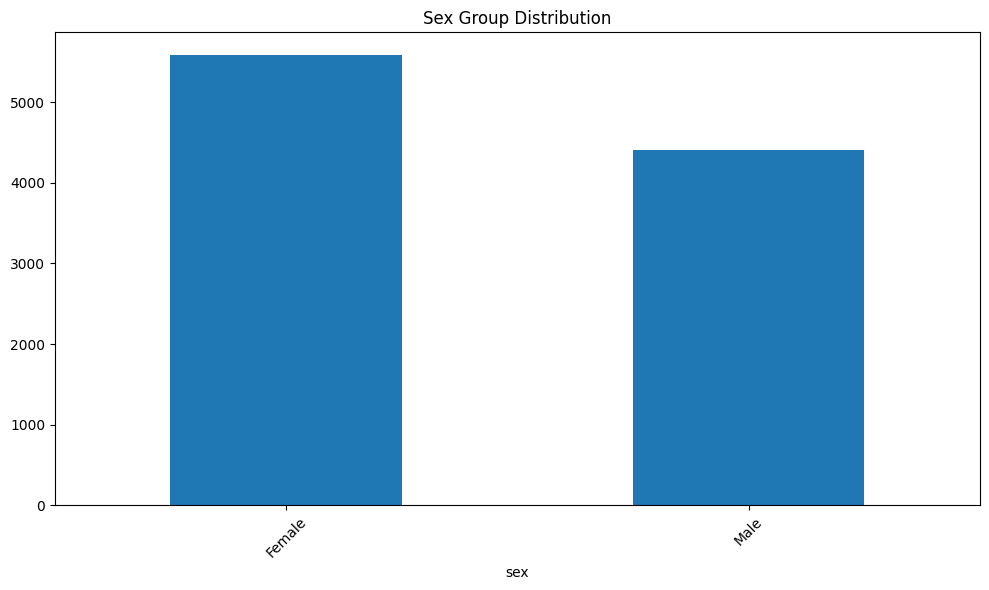

In [2]:
# TODO: Type conversions
# 1. Use transform_types() to convert enrollment_date to datetime
final_df = df.copy()
final_df = transform_types(final_df, {'enrollment_date': 'datetime'})
# 2. Convert categorical columns ('site', 'intervention_group', 'sex') to category dtype
categorical_cols = ['site', 'intervention_group', 'sex']
for col in categorical_cols:
    final_df[col] = final_df[col].astype('category')
# 3. Ensure all numeric columns are proper numeric types
numeric_cols = final_df.select_dtypes(include=['object']).columns
for col in numeric_cols:
    final_df[col] = pd.to_numeric(final_df[col], errors='ignore')

print("Numeric columns and their dtypes after conversion:")
# 4. Display the updated dtypes using df.dtypes
display(final_df.dtypes)

#5. Visualizations OF distributions of numeric columns series
numeric_cols = final_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plot_distribution(final_df[col], title=f'Distribution of {col}')


#6 Visualizations OF values count after type conversion

plot_value_counts(final_df['site'].value_counts(), 'Site Distribution')
plot_value_counts(final_df['intervention_group'].value_counts(), 'Intervention Group Distribution')
plot_value_counts(final_df['sex'].value_counts(), 'Sex Group Distribution')

## Part 2: Feature Engineering (8 points)

Create these new calculated columns:

1. `cholesterol_ratio` = cholesterol_ldl / cholesterol_hdl
2. `bp_category` = categorize systolic BP:
   - 'Normal': < 120
   - 'Elevated': 120-129
   - 'High': >= 130
3. `age_group` using `create_bins()` utility:
   - Bins: [0, 40, 55, 70, 100]
   - Labels: ['<40', '40-54', '55-69', '70+']
4. `bmi_category` using standard BMI categories:
   - Underweight: <18.5
   - Normal: 18.5-24.9
   - Overweight: 25-29.9
   - Obese: >=30

In [3]:
# TODO: Calculate cholesterol ratio
# 1. Cholesterol ratio
final_df['cholesterol_ratio'] = final_df['cholesterol_total'] / final_df['cholesterol_hdl']
print("Cholesterol ratio calculated and added to DataFrame.", final_df['cholesterol_ratio'].head())


Cholesterol ratio calculated and added to DataFrame. 0    2.181818
1    3.551724
2    3.071429
3    3.571429
4    2.371795
Name: cholesterol_ratio, dtype: float64


In [4]:
# TODO: Categorize blood pressure
def categorize_bp(systolic):
    if systolic < 120:
        return 'Normal'
    elif 120 <= systolic <= 129:
        return 'Elevated'
    else:
        return 'High'

final_df['bp_category'] = final_df['systolic_bp'].apply(categorize_bp)


**Note:** The `create_bins()` function has an optional `new_column` parameter. If you don't specify it, the new column will be named `{original_column}_binned`. You can use `new_column='age_group'` to give it a custom name.


In [5]:
# Create age groups
bins = [0, 40, 55, 70, 100]
labels = ['<40', '40-54', '55-69', '70+']
# create_bins expects a column name (string) and will return the DataFrame with the new column
final_df = create_bins(final_df, 'age', bins=bins, labels=labels, new_column='age_group')
# Ensure the new column is categorical with the provided labels
final_df['age_group'] = final_df['age_group'].astype('category')
print('Age groups added. Unique groups:', final_df['age_group'].cat.categories)

Age groups added. Unique groups: Index(['<40', '40-54', '55-69', '70+'], dtype='object')


In [6]:
# TODO: Create BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi <= 24.9:
        return 'Normal'
    elif 25 < bmi <= 29.9:
        return 'Overweight'
    else:
        return 'Obese'

final_df['bmi_category'] = final_df['bmi'].apply(categorize_bmi)

## Part 3: String Cleaning (2 points)

If there are any string columns that need cleaning:
1. Convert to lowercase
2. Strip whitespace
3. Replace any placeholder values

In [7]:
# TODO: String cleaning
string_cols = final_df.select_dtypes(include='object').columns
print("String columns before cleaning:", string_cols.tolist())

for col in string_cols:
    final_df[col] = final_df[col].str.strip().str.lower().replace(['na', 'n/a', 'none', 'null', '-', 'missing', ''], 
    pd.NA
)


String columns before cleaning: ['patient_id', 'outcome_cvd', 'dropout', 'bp_category', 'bmi_category']


## Part 4: One-Hot Encoding (5 points)

Create dummy variables for categorical columns:
1. One-hot encode 'intervention_group' using `pd.get_dummies()`
2. One-hot encode 'site'
3. Drop the original categorical columns
4. Show the new shape and column names

In [8]:
# One-hot encoding with safety checks
# 1) Intervention group dummies if column exists
if 'intervention_group' in final_df.columns:
    intervention_dummies = pd.get_dummies(final_df['intervention_group'], prefix='interv')
    print("One-hot encoding completed for 'intervention_group'.", intervention_dummies.head())
    final_df = pd.concat([final_df, intervention_dummies], axis=1)
else:
    print("Warning: 'intervention_group' column not found — skipping dummy encoding for intervention.")

# 2) Site dummies if column exists
if 'site' in final_df.columns:
    site_dummies = pd.get_dummies(final_df['site'], prefix='site')
    print("One-hot encoding completed for 'site'.", site_dummies.head())
    final_df = pd.concat([final_df, site_dummies], axis=1)
else:
    print("Warning: 'site' column not found — skipping dummy encoding for site.")

# drop original columns after encoding if they existed
cols_to_drop = [c for c in ['intervention_group', 'site'] if c in final_df.columns]
if cols_to_drop:
    final_df = final_df.drop(columns=cols_to_drop)

# 4 Show the new shape and columns names
print("Final DataFrame shape:", final_df.shape)
print("Final DataFrame columns (sample):", final_df.columns.tolist()[:30])

One-hot encoding completed for 'intervention_group'.    interv_Control  interv_Treatment A  interv_Treatment B
0            True               False               False
1            True               False               False
2           False               False                True
3           False               False                True
4           False                True               False
One-hot encoding completed for 'site'.    site_Site A  site_Site B  site_Site C  site_Site D  site_Site E
0        False         True        False        False        False
1         True        False        False        False        False
2        False        False         True        False        False
3        False        False        False         True        False
4        False        False        False        False         True
Final DataFrame shape: (10000, 29)
Final DataFrame columns (sample): ['patient_id', 'age', 'sex', 'bmi', 'enrollment_date', 'systolic_bp', 'diastolic_bp', 'ch

## Part 5: Save Transformed Data

Save the fully transformed dataset to `output/q6_transformed_data.csv`

In [9]:
# Save transformed data
final_df.to_csv('output/q6_transformed_data.csv', index=False)
print('Saved transformed data to output/q6_transformed_data.csv')

Saved transformed data to output/q6_transformed_data.csv
